# Determine noise levels per patient per coil.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import h5py
from numpy.fft import fftshift, ifft2
import random
import SimpleITK as sitk
from typing import Dict, Any, List, Tuple
import scipy.ndimage


# shape of the data: (averages, slices, coils, rows, columns)
def load_patient_data(patient_dict: dict, debug=False) -> dict:
    """
    Loads the k-space and reconstruction data for a given patient from the h5 file.
    
    Args:
    - patient_dict (dict): Dictionary containing the necessary paths and indices for the patient.
    
    Returns:
    - patient_dict (dict): The updated dictionary containing loaded data.
    """
    with h5py.File(patient_dict["h5_path"], 'r') as f:
        print(f"\nLoaded data for {patient_dict['h5_path']}")

        patient_dict["kspace"] = f['kspace'][:]
        patient_dict["slice_ksp"] = patient_dict["kspace"][patient_dict["avg_idx"], 
                                                          patient_dict["slice_idx"], 
                                                          patient_dict["coil_idx"], ...]
        print(f"Slice ksp shape: {patient_dict['slice_ksp'].shape}")
        
        # Optional: Convert to image space (inverse FFT)
        patient_dict["slice_img"] = np.fft.ifft2(patient_dict["slice_ksp"])
        
        if debug:
            for key in f.keys():
                print(key)
            for attr in f.attrs:
                print(attr, f.attrs[attr])

        # Debug: Print the shape and dtype of the k-space data
        print(f"\nkspace Shape: {patient_dict['kspace'].shape}")
        print(f"kspace dtpe: {patient_dict['kspace'].dtype}")
        
    return patient_dict


tmpdir = Path('/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp')
print(tmpdir)

/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp


In [2]:
pat3 = {
    "h5_path": Path("/scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358/h5s/meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2.h5"),
    "pat_id": "0003_umcg_pst_ksps",
    "kspace": None,
    "slice_idx": 15,          
    "avg_idx": 0,                 #  0: first avg, 1: second avg, 2: third avg
    "coil_idx": 0,                #  0: first coil, 1: second coil, 2: third coil etc .. 19: last coil
    "slice_ksp": None,            # The slice data from the kspace
    "slice_img": None,            # The slice data from the recon
}
pat4 = {
    "h5_path": "/scratch/p290820/datasets/003_umcg_pst_ksps/data/0004_ANON9616598/h5s/meas_MID00460_FID707792_T2_TSE_tra_obl-out_2.h5",
    "pat_id": "0004_ANON9616598",
    "kspace": None,
    "slice_idx": 15,          
    "avg_idx": 0,                 #  0: first avg, 1: second avg, 2: third avg
    "coil_idx": 0,                #  0: first coil, 1: second coil, 2: third coil etc .. 19: last coil
    "slice_ksp": None,            # The slice data from the kspace
    "slice_img": None,            # The slice data from the recon
}

pat3 = load_patient_data(pat3, debug=True)
pat4 = load_patient_data(pat4, debug=True)


Loaded data for /scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358/h5s/meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2.h5
Slice ksp shape: (768, 651)
ismrmrd_header
kspace
acq_mat_dcm_hdr [  0 384 307   0]
acquisition AXT2
cols_dcm_hdr 768
do_norm_to_ref True
do_rm_zero_pad True
max 0.0004
max_phase_crop None
n_averages_dcm_hdr 3.0
n_phase_enc_steps_dcm_hdr 651
norm 0.12
pat_pos_dcm_hdr HFS
patient_id ANON5046358
patient_id_seq 0003
percent_phase_fov_dcm_hdr 100.0
percent_sampling_dcm_hdr 80.0
pixel_spacing_dcm_hdr [0.234375 0.234375]
rows_dcm_hdr 768

kspace Shape: (3, 30, 20, 768, 651)
kspace dtpe: complex64

Loaded data for /scratch/p290820/datasets/003_umcg_pst_ksps/data/0004_ANON9616598/h5s/meas_MID00460_FID707792_T2_TSE_tra_obl-out_2.h5
Slice ksp shape: (640, 551)
ismrmrd_header
kspace
acq_mat_dcm_hdr [  0 320 256   0]
acquisition AXT2
cols_dcm_hdr 640
do_norm_to_ref True
do_rm_zero_pad True
max 0.0004
max_phase_crop None
n_averages_dcm_hdr 3.0
n_phase_enc_step

In [ ]:
def collapse_averages(kspace_data: np.ndarray) -> np.ndarray:
    """
    Collapse the averages in the k-space data.
    
    The input kspace_data must have shape (averages, slices, coils, rows, columns)
    with exactly 3 averages. The combination is performed as:
        combined_kspace = (avg1 + avg3) / 2 + avg2
    
    Args:
        kspace_data (np.ndarray): Complex k-space data.
        
    Returns:
        np.ndarray: Combined k-space data with shape (slices, coils, rows, columns).
    """
    assert isinstance(kspace_data, np.ndarray), "kspace_data must be a numpy array"
    assert kspace_data.ndim == 5, "Expected kspace_data to have 5 dimensions, got {}".format(kspace_data.ndim)
    assert kspace_data.shape[0] == 3, f"Expected 3 averages, got {kspace_data.shape[0]}"
    
    combined_kspace = ((kspace_data[0, ...] + kspace_data[2, ...]) / 2) + kspace_data[1, ...]
    return combined_kspace


# lets add it to pat3 and pat4 as dict key and value
pat3["combined_kspace"] = collapse_averages(pat3["kspace"])
pat4["combined_kspace"] = collapse_averages(pat4["kspace"])


In [4]:

print(f"Combined k-space shape: {pat3['combined_kspace'].shape}")
print(f"Combined k-space shape: {pat4['combined_kspace'].shape}")

Combined k-space shape: (30, 20, 768, 651)
Combined k-space shape: (31, 26, 640, 551)


In [ ]:
def transform_kspace_to_image_unitary(kspace_data: np.ndarray) -> np.ndarray:
    """
    Convert k-space data to image space using a unitary (energy-preserving) 2D inverse FFT.

    This function assumes the input k-space data has the shape:
        (slices, coils, rows, columns)
    It applies the following steps:
      1. Centers the k-space data using ifftshift.
      2. Performs a 2D inverse FFT with unitary normalization ('ortho').
      3. Centers the resulting image with fftshift.

    Using unitary normalization (norm='ortho') ensures that the FFT
    preserves the energy of the signal. In practical terms, if the k-space data
    includes additive Gaussian noise with a certain variance, then the noise
    level in the image space will be identical. This property is crucial for
    quantitative analysis and ensures that noise in k-space is directly related
    to noise in image space.

    Args:
        kspace_data (np.ndarray): K-space data array of shape 
                                  (slices, coils, rows, columns).

    Returns:
        np.ndarray: The image space data array with the same shape.
    """
    assert isinstance(kspace_data, np.ndarray), "kspace_data must be a numpy array"
    assert np.iscomplexobj(kspace_data), "kspace_data must be complex-valued"
    assert kspace_data.ndim == 4, f"Expected kspace_data to have 4 dimensions, got {kspace_data.ndim}"
    
    # 1. Center the k-space data along the spatial dimensions
    shifted_kspace = np.fft.ifftshift(kspace_data, axes=(-2, -1))
    
    # 2. Apply a 2D inverse FFT with unitary normalization to preserve noise levels.
    #    The 'ortho' normalization ensures that the energy (and thus the noise variance)
    #    in the k-space data is preserved in the image space.
    img_space = np.fft.ifft2(shifted_kspace, axes=(-2, -1), norm='ortho')
    
    # 3. Center the resulting image
    img_space = np.fft.fftshift(img_space, axes=(-2, -1))
    
    return img_space

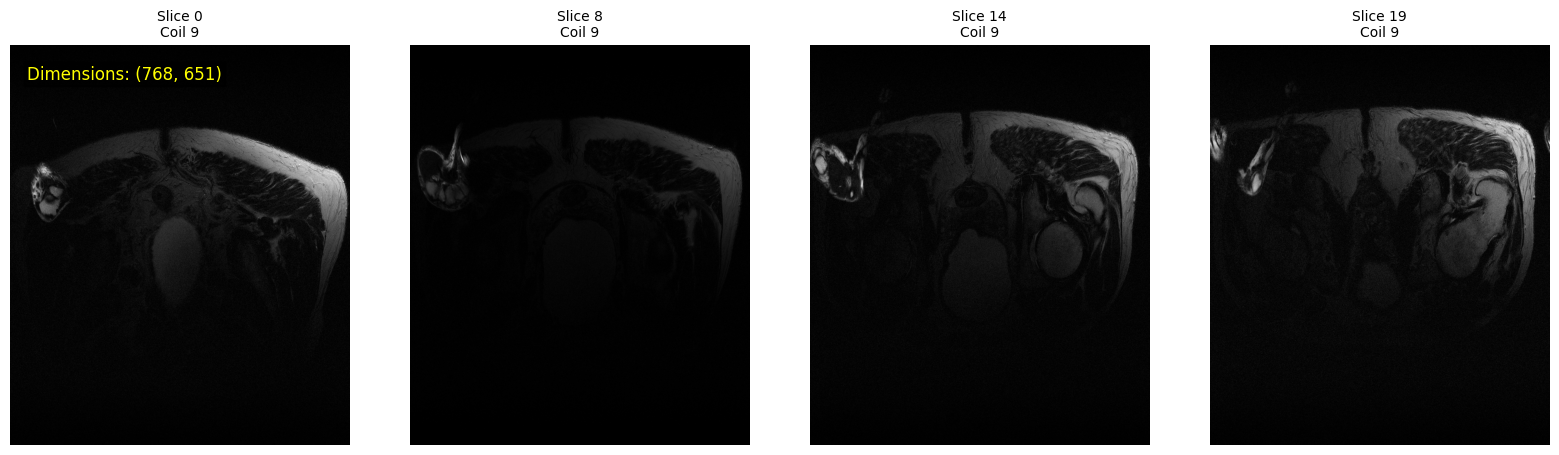

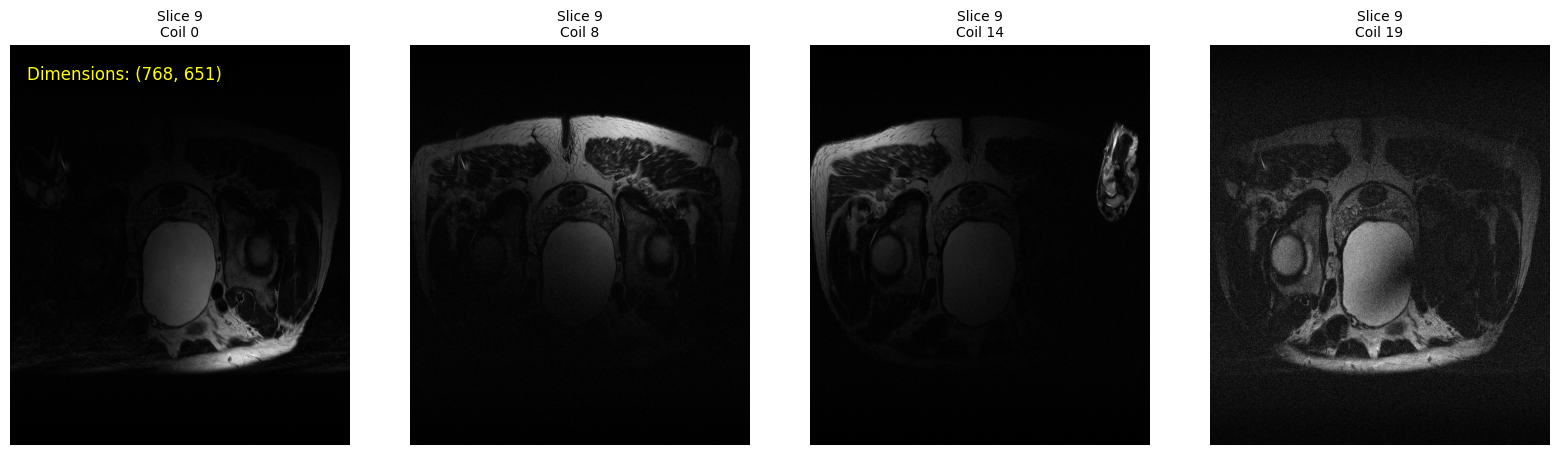

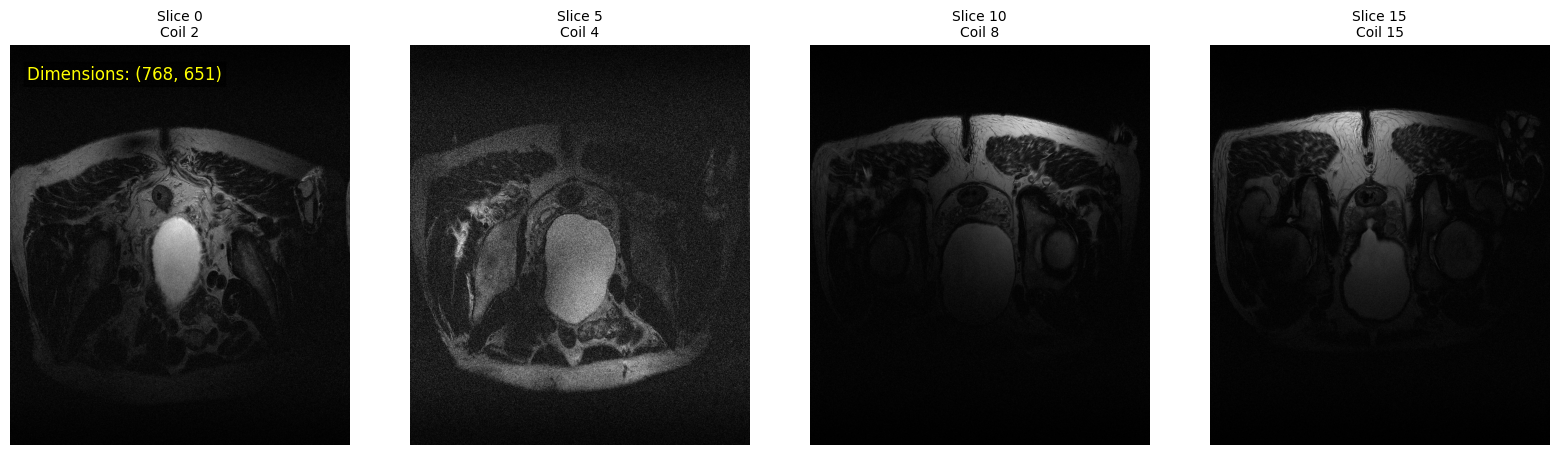

In [10]:

def plot_slice_coil_pairs(img_array: np.ndarray, slice_indices: list, coil_indices: list, cmap: str = 'gray'):
    """
    Plot a row of images, where each image is taken from the given slice and coil index pair.
    
    The image array is assumed to have the shape:
        (slices, coils, rows, columns)
    
    Args:
        img_array (np.ndarray): The image data array.
        slice_indices (list): List of slice indices.
        coil_indices (list): List of coil indices.
                              Both lists must be of the same length.
        cmap (str): Colormap for the images (default is 'gray').
    
    Raises:
        ValueError: If the length of slice_indices and coil_indices are not equal.
    
    Returns:
        None. Displays a matplotlib figure with the images.
    """
    if len(slice_indices) != len(coil_indices):
        raise ValueError("The lists for slice indices and coil indices must have the same length.")
    
    n_images = len(slice_indices)
    plt.figure(figsize=(4 * n_images, 4))
    
    for i, (s_idx, c_idx) in enumerate(zip(slice_indices, coil_indices)):
        ax = plt.subplot(1, n_images, i + 1)
        # Extract the image at the given slice and coil, and take the absolute value for display.
        img = np.abs(img_array[s_idx, c_idx])
        ax.imshow(img, cmap=cmap)
        ax.set_title(f"Slice {s_idx}\nCoil {c_idx}", fontsize=10)
        ax.axis('off')
        
        # For the leftmost image, add an annotation showing the image dimensions.
        if i == 0:
            dims = img.shape  # (rows, columns)
            ax.text(0.05, 0.95, f"Dimensions: {dims}", transform=ax.transAxes,
                    fontsize=12, color='yellow', verticalalignment='top',
                    bbox=dict(facecolor='black', alpha=0.5, pad=2))
    
    # Remove spacing between subplots.
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
    plt.show()

plot_slice_coil_pairs(pat3["combined_img"], slice_indices = [0, 8, 14, 19], coil_indices = [9, 9,  9, 9])
plot_slice_coil_pairs(pat3["combined_img"], slice_indices = [9, 9, 9 , 9 ], coil_indices = [0, 8, 14, 19])
plot_slice_coil_pairs(pat3["combined_img"], slice_indices = [0, 5, 10, 15], coil_indices = [2, 4, 8,  15])